In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load values

In [2]:
from scipy.io import loadmat
import numpy as np

FHR = loadmat("/content/drive/MyDrive/fbmi/ASII/data_FHR.mat")

f_sample = 4 # Hz
fhr = FHR["fhr"]
time = np.arange(len(fhr)).reshape(len(fhr), 1) / f_sample

### Define function for removing missing values

In [3]:
from scipy.interpolate import interp1d

def remove_missing_values(fhr):
  """Remove missing values (equals to zero)

  Args:
    fhr (np.array): fetal heart rate signal

  Returns:
    np.array: interpolated fetal heart rate signal
  """
  mask = fhr != 0
  interp_function = interp1d(time[mask], fhr[mask], fill_value="extrapolate")
  return interp_function(time)

### Show data with missing values and without missing values

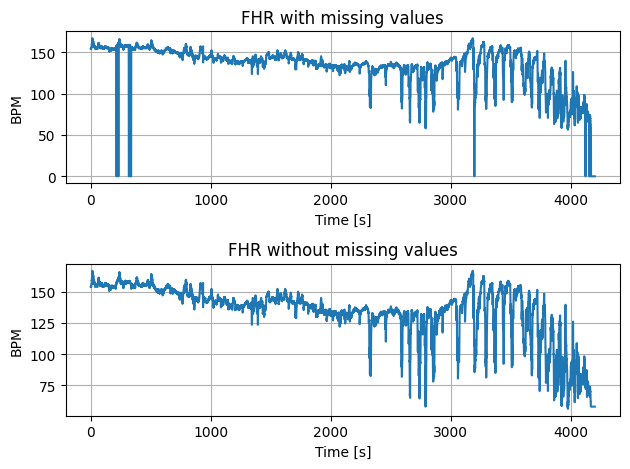

In [4]:
import matplotlib.pyplot as plt

fhr_interpolated = remove_missing_values(fhr)

_, ax = plt.subplots(2)

# before removing missing values
ax[0].plot(time, fhr)
ax[0].set_title('FHR with missing values')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('BPM')
ax[0].grid(True)

# after removing missing values
ax[1].plot(time, fhr_interpolated)
ax[1].set_title('FHR without missing values')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('BPM')
ax[1].grid(True)

plt.tight_layout()
plt.show()

### Define function for filtering the signal

In [5]:
from scipy.signal import butter, filtfilt

def get_baseline(fhr, cutoff_frequency):
  """Use Butterworth IIR filter to calculate baseline of FHR signal

  Args:
    fhr (np.array): fetal heart rate signal

  Returns:
    np.array: filtered FHR signal
  """
  order = 3
  b, a = butter(order, cutoff_frequency, btype='low', analog=False)

  return filtfilt(b, a, fhr.reshape(len(fhr))).reshape(len(fhr), 1)

### Show signal and baseline in one plot

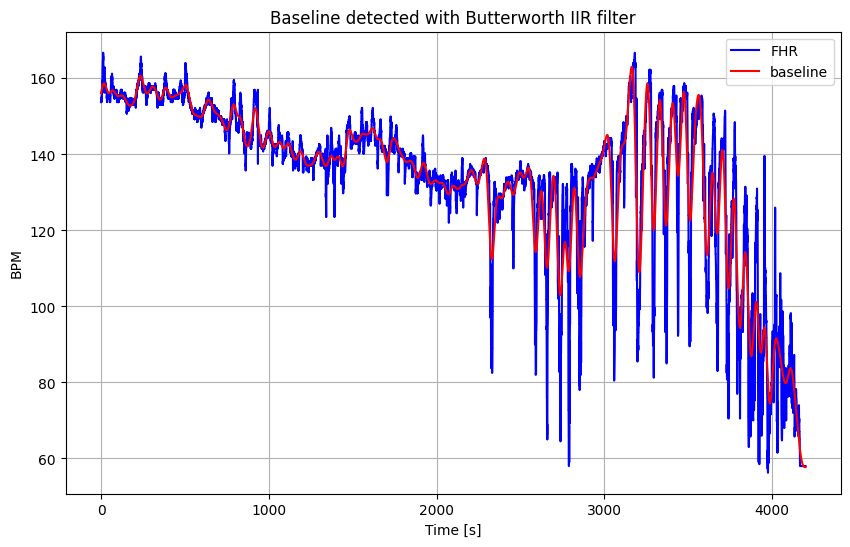

In [6]:
cutoff_frequency = 0.008 # Hz
baseline = get_baseline(fhr_interpolated, cutoff_frequency)

plt.figure(figsize=(10, 6))
plt.plot(time, fhr_interpolated, label='FHR', color='blue')
plt.plot(time, baseline, label='baseline', color='red')
plt.xlabel('Time [s]')
plt.ylabel('BPM')
plt.title("Baseline detected with Butterworth IIR filter")
plt.legend()
plt.grid(True)
plt.show()

### Define function for detect acceleration and deceleration

In [7]:
def remove_acceleration_and_deceleration(fhr, baseline, under_limit, over_limit):
  """If FHR signal exceeds over_limit for 18 seconds and more
     or FHR signal is lower than under_limit for 18 seconds and more
     corresponding elements of FHR are set to zero.

  Args:
    fhr (numpy.array): fetal heart rate signal
    baseline (numpy.array): filtered heart rate signal
    under_limit (int): lower limit of BPM (max difference between signal and baseline)
    over_limit (int): higher limit of BPM (max difference between signal and baseline)

  Returns:
    numpy.array: fetal heart rate singnal with zero values
  """

  time_limit = 18 # s
  low = 0
  high = 0
  for i in range(len(fhr)):
    # element counter for lower limit
    if fhr[i] < baseline[i] - under_limit:
      if high == 0:
        low += 1
      else:
        high = 0
    # element counter for higher limit
    elif fhr[i] > baseline[i] + over_limit:
      if low == 0:
        high += 1
      else:
        low = 0
    # clear counters if condition is not met
    else:
      low = 0
      high = 0
    # clear all corresponding elements if lower condition is met
    if low >= time_limit:
      if i < len(fhr) - 1:
        fhr[i-low+1:i+1] = 0
      else:
        fhr[i-low+1:]
    # clear all corresponding elements if higher condition is met
    if high >= time_limit:
      if i < len(fhr) - 1:
        fhr[i-high+1:i+1] = 0
      else:
        fhr[i-high+1:]

  return fhr

### Show signal without decelation and acceleration

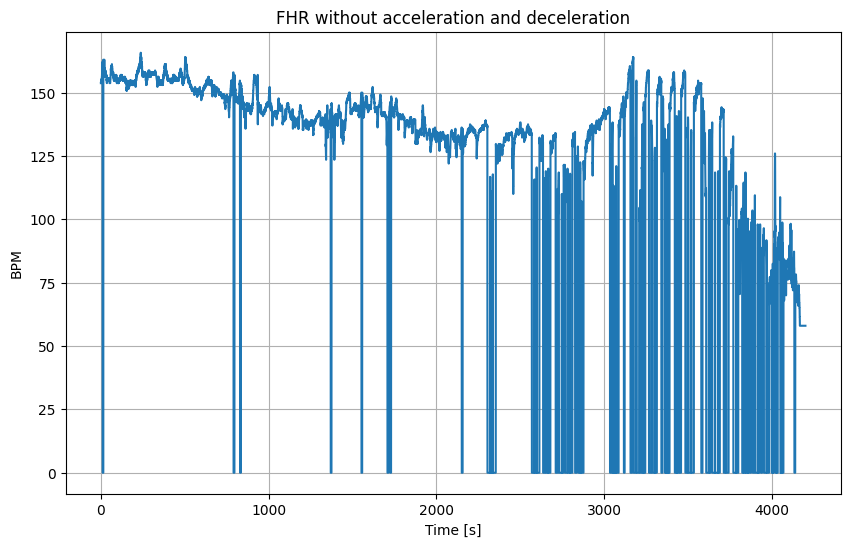

In [8]:
under_limit = 5 # BPM
over_limit = 5 # BPM
new_fhr = remove_acceleration_and_deceleration(fhr_interpolated, baseline, under_limit, over_limit)

plt.figure(figsize=(10, 6))
plt.plot(time, new_fhr)
plt.xlabel('Time [s]')
plt.ylabel('BPM')
plt.title("FHR without acceleration and deceleration")
plt.grid(True)
plt.show()

### Create loop for signal processing and plot the result

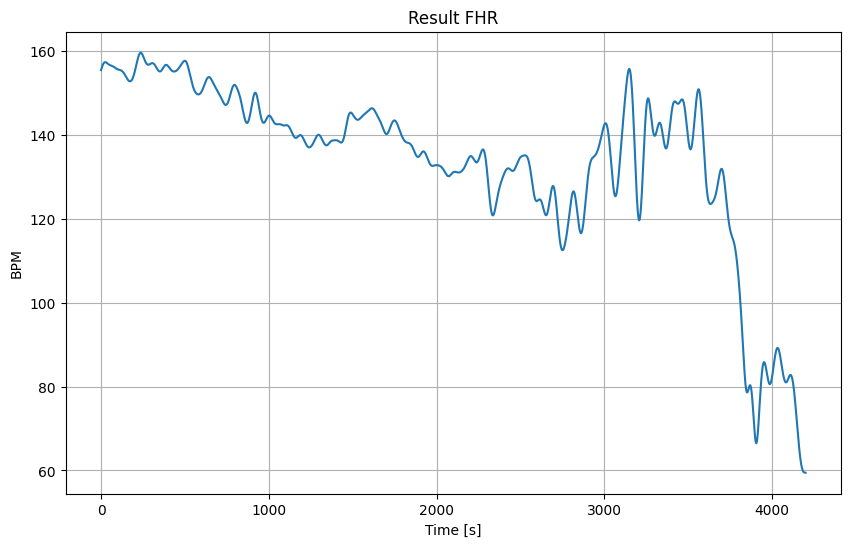

In [9]:
cutoff_frequency = 0.006 # Hz
under_limit = 5 # BPM
over_limit = 5 # BPM

for i in range(3):
  if i == 2:
    under_limit = 10 # BPM
  new_fhr = remove_missing_values(new_fhr)
  baseline = get_baseline(new_fhr, cutoff_frequency)
  new_fhr = remove_acceleration_and_deceleration(new_fhr, baseline, under_limit, over_limit)

final_baseline = baseline = get_baseline(new_fhr, cutoff_frequency)

# result
plt.figure(figsize=(10, 6))
plt.plot(time, final_baseline)
plt.xlabel('Time [s]')
plt.ylabel('BPM')
plt.title("Result FHR")
plt.grid(True)
plt.show()